# Configuration

In [1]:
# --- Transformer Configuration ---

# GPT-2
# MODEL_NAME = "gpt2"
# We target the output projection of the MLP layer in a specific block
# LAYER_IDX = 1
# LAYER_NAME = f"transformer.h.{LAYER_IDX}.mlp.c_proj" # Output projection of MLP
# LAYER_NAME = f"transformer.h.{LAYER_IDX}.attn.c_proj" # Output projection of Attention
# Alternative: f"transformer.h.{LAYER_IDX}" # Output of the whole block (residual stream)
# ACTIVATION_DIM = 768

MODEL_NAME = "google/gemma-3-1b-it"
LAYER_IDX = 25
LAYER_NAME = f"model.layers.{LAYER_IDX}.mlp.down_proj"
ACTIVATION_DIM = 1152

In [2]:
# --- Dataset Configuration ---
DATASET_NAME = "wikitext"
DATASET_CONFIG = "wikitext-103-raw-v1" # Or "wikitext-2-raw-v1" for smaller

DATASET_SPLIT = "train"
NUM_ACTIVATIONS_TO_STORE = 3000000 # Max activations to collect (adjust based on RAM)
MAX_SEQ_LENGTH = 128 # Max token length for processing sequences
UNIT_NORM = True

In [3]:
# --- SAE Configuration ---
SAE_EXPANSION_FACTOR = 8 # How many times larger the SAE hidden dim is than the activation dim
SAE_HIDDEN_DIM = ACTIVATION_DIM * SAE_EXPANSION_FACTOR
L1_COEFF = 3e-4 # Sparsity penalty strength

In [4]:
# --- Training Configuration ---
BATCH_SIZE = 512
LEARNING_RATE = 3e-3
NUM_EPOCHS = 300
PRINT_INTERVAL = 100
INITIAL_LR_WARMUP_STEPS = 500
FINAL_LR_FACTOR = 0.5

In [5]:
# --- Analysis Configuration ---
NUM_TOP_FEATURES_TO_ANALYZE = 100
ACTIVITY_THRESHOLD = 1e-6 # Threshold to consider a feature non-dead

In [6]:
# -- General Configuration ---
from secret_tokens import access_tokens
token = access_tokens["hf"]

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer, Gemma3ForCausalLM
from datasets import load_dataset
from tqdm.auto import tqdm  # Use auto version for notebook compatibility
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
import math

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Setup

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA RTX A1000 6GB Laptop GPU


In [8]:
print(f"Loading model: {MODEL_NAME}")
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device) # for gpt2
#model = Gemma3ForCausalLM.from_pretrained(MODEL_NAME, token=token).to(device) # for gemma
model.eval()

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=token)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading model: google/gemma-3-1b-it
Loading tokenizer: google/gemma-3-1b-it


# Data

In [10]:
activation_storage = []

# Remove bos token
bos_token_id = tokenizer.bos_token_id

# Register hook to save the activation
def get_activation_hook_no_flatten(layer_name):
    """Creates a hook function to capture activations."""
    def hook(model, input, output):
        act_tensor = output[0] if isinstance(output, tuple) else output
        activation_storage.append(act_tensor.detach().cpu().to(torch.float32))

    target_module = dict(model.named_modules())[layer_name]
    handle = target_module.register_forward_hook(hook)
    return handle

# Register the non-flattening hook
print(f"Registering hook on layer: {LAYER_NAME}")
hook_handle = get_activation_hook_no_flatten(LAYER_NAME)

activation_storage_filtered = []
token_storage = []

print(f"Loading dataset: {DATASET_NAME} ({DATASET_CONFIG})")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"{DATASET_SPLIT}", streaming=True)

print("Processing dataset and extracting activations (Aligning Tokens and Activations)...")
num_processed_tokens = 0 # Track actual non-padding tokens processed
pbar = tqdm(total=NUM_ACTIVATIONS_TO_STORE, desc="Extracting Aligned Activations/Tokens")

for example in iter(dataset):
    if num_processed_tokens >= NUM_ACTIVATIONS_TO_STORE:
        break

    text = example['text'] # For wikitext
    # text = example['content'] # codeparrot
    if not text or len(text.strip()) == 0:
      continue

    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", max_length=MAX_SEQ_LENGTH, padding="max_length", truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device) # Shape: (batch_size, seq_len)
    
    activation_storage.clear()

    with torch.no_grad():
        model(input_ids=input_ids, attention_mask=attention_mask)

    # --- Retrieve activation (assuming hook appended to global list) ---
    if not activation_storage:
         print("Warning: Hook did not capture activation for a batch. Skipping.")
         continue
        
    batch_activations = activation_storage[0]

    # Ensure shapes match for filtering
    if batch_activations.shape[0] != input_ids.shape[0] or batch_activations.shape[1] != input_ids.shape[1]:
       print(f"Warning: Activation shape {batch_activations.shape} mismatch with input_ids {input_ids.shape}. Check hook logic. Skipping batch.")
       continue

    # --- Filter Activations and Tokens based on Attention Mask ---
    cpu_input_ids = input_ids.cpu().numpy() # (batch_size, seq_len)
    cpu_attention_mask = attention_mask.cpu().numpy().astype(bool) # (batch_size, seq_len)

    # Flatten batch and sequence dimensions for filtering
    flat_activations = batch_activations.view(-1, ACTIVATION_DIM) # (batch*seq, hidden)
    flat_input_ids = cpu_input_ids.flatten() # (batch*seq,)
    flat_attention_mask = cpu_attention_mask.flatten() # (batch*seq,)

    # Filter <bos> token
    not_bos_mask = (flat_input_ids != bos_token_id)
    final_filter_mask = flat_attention_mask & not_bos_mask
    
    # Select only items where final_filter_mask is True
    filtered_activations = flat_activations[final_filter_mask]
    filtered_tokens = flat_input_ids[final_filter_mask]

    # Store filtered tokens
    if filtered_activations.shape[0] > 0: # Only store if there are non-padding tokens
        activation_storage_filtered.append(filtered_activations)
        newly_added_tokens = filtered_tokens.tolist()
        token_storage.extend(newly_added_tokens)

        # --- Update Progress ---
        num_processed_tokens += len(newly_added_tokens)
        pbar.update(len(newly_added_tokens))

pbar.close()
hook_handle.remove() # Remove the hook

if not activation_storage_filtered:
    raise ValueError("No activations were extracted/stored after filtering. Check data or hook.")

all_activations = torch.cat(activation_storage_filtered, dim=0)
print(f"Total ALIGNED activations extracted: {all_activations.shape[0]}")
print(f"Total ALIGNED tokens stored: {len(token_storage)}")
print(f"Activation tensor final shape: {all_activations.shape}") # Should be (N, ACTIVATION_DIM)
print(f"Token storage final length: {len(token_storage)}")      # N should match above

# Check if the lengths match (they should now)
if all_activations.shape[0] != len(token_storage):
    print(f"CRITICAL WARNING: Mismatch between activation count ({all_activations.shape[0]}) and token count ({len(token_storage)}) AFTER filtering!")
else:
    print("Activation and token counts match. Alignment successful.")

# Normalize activations for SAE training
act_mean = torch.mean(all_activations, dim=0, keepdim=True)
act_norms = torch.norm(all_activations, dim=1, keepdim=True) + 1e-6 # Add epsilon for stability
if UNIT_NORM:
    all_activations = (all_activations - act_mean) / act_norms
else:
    all_activations = all_activations - act_mean
print("Filtered activations normalized (unit norm per vector).")

Registering hook on layer: model.layers.25.mlp.down_proj
Loading dataset: wikitext (wikitext-103-raw-v1)
Processing dataset and extracting activations (Aligning Tokens and Activations)...


Extracting Aligned Activations/Tokens:   0%|          | 0/3000000 [00:00<?, ?it/s]

Total ALIGNED activations extracted: 3000008
Total ALIGNED tokens stored: 3000008
Activation tensor final shape: torch.Size([3000008, 1152])
Token storage final length: 3000008
Activation and token counts match. Alignment successful.
Filtered activations normalized (unit norm per vector).


In [11]:
# Convert to PyTorch DataLoader for training
activation_dataset = torch.utils.data.TensorDataset(all_activations)
activation_loader = torch.utils.data.DataLoader(activation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
import gc
gc.collect()
if device == torch.device("cuda"):
    torch.cuda.empty_cache()

# Training

In [13]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, input_dim, bias=True)

        self.relu = nn.ReLU()
        nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded

    def encode(self, x):
      return self.relu(self.encoder(x))

# Initialize SAE
print(f"Initializing SAE with ACTIVATION_DIM={ACTIVATION_DIM}, SAE_HIDDEN_DIM={SAE_HIDDEN_DIM}")
sae_model = SparseAutoencoder(ACTIVATION_DIM, SAE_HIDDEN_DIM).to(device)
print("SAE Model:")
print(sae_model)

Initializing SAE with ACTIVATION_DIM=1152, SAE_HIDDEN_DIM=9216
SAE Model:
SparseAutoencoder(
  (encoder): Linear(in_features=1152, out_features=9216, bias=True)
  (decoder): Linear(in_features=9216, out_features=1152, bias=True)
  (relu): ReLU()
)


In [14]:
def sae_loss(original_activations, encoded_activations, decoded_activations, l1_coeff):
    """Calculates SAE loss: MSE + L1 penalty on encoded activations."""
    mse_loss = nn.functional.mse_loss(decoded_activations, original_activations)

    l1_loss = torch.mean(torch.abs(encoded_activations))

    total_loss = mse_loss + l1_coeff * l1_loss
    return total_loss, mse_loss, l1_loss

In [15]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"runs/{DATASET_NAME}/{MODEL_NAME.replace('/', '_')}_{LAYER_NAME}_sae_training_logs_{timestamp}" # You can customize this path
os.makedirs(log_dir, exist_ok=True) # Create the directory if it doesn't exist
writer = SummaryWriter(log_dir=log_dir)
print(f"TensorBoard logs will be saved to: {log_dir}")
print("Run 'tensorboard --logdir runs' (or your specific log_dir parent) to view logs.")

TensorBoard logs will be saved to: runs/wikitext/google_gemma-3-1b-it_model.layers.25.mlp.down_proj_sae_training_logs_20250516-172556
Run 'tensorboard --logdir runs' (or your specific log_dir parent) to view logs.


In [16]:
print("Starting SAE training...")
sae_model.compile()
sae_model.train()
training_losses = {'total': [], 'mse': [], 'l1': [], 'l0': []} # Track losses and L0
global_step = 0

LR_DECAY_STEPS = NUM_EPOCHS * len(activation_loader) - INITIAL_LR_WARMUP_STEPS

optimizer = optim.Adam(sae_model.parameters(), lr=LEARNING_RATE)
base_lr = LEARNING_RATE

for epoch in range(NUM_EPOCHS):
    epoch_total_loss = 0
    epoch_mse_loss = 0
    epoch_l1_loss = 0
    epoch_l0_norm = 0 # Track average number of non-zero features

    pbar_train = tqdm(activation_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for i, batch in enumerate(pbar_train):
        # Batch is a list containing one tensor: the activations
        original_acts = batch[0].to(device)
        
        # Learning rate scheduling
        if global_step < INITIAL_LR_WARMUP_STEPS:
            current_lr = base_lr * (global_step + 1) / INITIAL_LR_WARMUP_STEPS
        elif global_step < INITIAL_LR_WARMUP_STEPS + LR_DECAY_STEPS:
            steps_after_initial_warmup = (global_step - INITIAL_LR_WARMUP_STEPS) / LR_DECAY_STEPS
            cosine_decay = 0.5 * (1 + math.cos(math.pi * steps_after_initial_warmup))
            current_lr = base_lr * ((1 - FINAL_LR_FACTOR) * cosine_decay + FINAL_LR_FACTOR) # Interpolate
            current_lr = max(current_lr, base_lr * FINAL_LR_FACTOR) # Ensure minimum LR. It is not needed, but for safety reasons I keep it here
        else:
            current_lr = base_lr * FINAL_LR_FACTOR

        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        
        encoded, decoded = sae_model(original_acts)
        loss, mse, l1 = sae_loss(original_acts, encoded, decoded, L1_COEFF)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        global_step += 1
        
        epoch_total_loss += loss.item()
        epoch_mse_loss += mse.item()
        epoch_l1_loss += l1.item()
        
        l0 = torch.sum(encoded > 1e-6, dim=1).float().mean().item()
        epoch_l0_norm += l0

        if (i + 1) % PRINT_INTERVAL == 0 or i == len(activation_loader) - 1:
             pbar_train.set_postfix({
                 "Total Loss": f"{loss.item():.8f}",
                 "MSE": f"{mse.item():.8f}",
                 "L1": f"{l1.item():.8f}",
                 "L0": f"{l0:.2f}" # Avg active features in current batch
             })
        
        
    # Average losses for the epoch
    avg_total_loss = epoch_total_loss / len(activation_loader)
    avg_mse_loss = epoch_mse_loss / len(activation_loader)
    avg_l1_loss = epoch_l1_loss / len(activation_loader)
    avg_l0_norm = epoch_l0_norm / len(activation_loader)

    training_losses['total'].append(avg_total_loss)
    training_losses['mse'].append(avg_mse_loss)
    training_losses['l1'].append(avg_l1_loss)
    training_losses['l0'].append(avg_l0_norm)

    writer.add_scalar('Loss/Epoch/Total', avg_total_loss, epoch)
    writer.add_scalar('Loss/Epoch/MSE', avg_mse_loss, epoch)
    writer.add_scalar('Loss/Epoch/L1', avg_l1_loss, epoch)
    writer.add_scalar('L0_Norm/Epoch', avg_l0_norm, epoch)
    writer.add_scalar('LR/Epoch', current_lr, epoch)


    print(f"Epoch {epoch+1} Complete: Avg Total Loss={avg_total_loss:.12f}, Avg MSE={avg_mse_loss:.12f}, Avg L1={avg_l1_loss:.7f}, Avg L0={avg_l0_norm:.2f}")

print("SAE Training finished.")

Starting SAE training...


Epoch 1/300:   0%|          | 0/5860 [00:00<?, ?it/s]

/home/sd23297/Documents/mechanistic-interpretability/env/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0516 17:26:00.706000 98838 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1 Complete: Avg Total Loss=0.000008167339, Avg MSE=0.000007222135, Avg L1=0.0031507, Avg L0=5206.98


Epoch 2/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 2 Complete: Avg Total Loss=0.000003412253, Avg MSE=0.000002781160, Avg L1=0.0021036, Avg L0=4814.34


Epoch 3/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 3 Complete: Avg Total Loss=0.000002474187, Avg MSE=0.000001940919, Avg L1=0.0017776, Avg L0=4095.71


Epoch 4/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 4 Complete: Avg Total Loss=0.000001867953, Avg MSE=0.000001405053, Avg L1=0.0015430, Avg L0=3303.13


Epoch 5/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 5 Complete: Avg Total Loss=0.000001490633, Avg MSE=0.000001075688, Avg L1=0.0013831, Avg L0=2755.02


Epoch 6/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 6 Complete: Avg Total Loss=0.000001268674, Avg MSE=0.000000885201, Avg L1=0.0012782, Avg L0=2407.63


Epoch 7/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 7 Complete: Avg Total Loss=0.000001157407, Avg MSE=0.000000794977, Avg L1=0.0012081, Avg L0=2169.47


Epoch 8/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 8 Complete: Avg Total Loss=0.000001077655, Avg MSE=0.000000730213, Avg L1=0.0011581, Avg L0=1988.49


Epoch 9/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 9 Complete: Avg Total Loss=0.000001026035, Avg MSE=0.000000690233, Avg L1=0.0011193, Avg L0=1863.36


Epoch 10/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 10 Complete: Avg Total Loss=0.000000987717, Avg MSE=0.000000661262, Avg L1=0.0010882, Avg L0=1762.89


Epoch 11/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 11 Complete: Avg Total Loss=0.000000956737, Avg MSE=0.000000638106, Avg L1=0.0010621, Avg L0=1676.21


Epoch 12/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 12 Complete: Avg Total Loss=0.000000923171, Avg MSE=0.000000610974, Avg L1=0.0010407, Avg L0=1613.28


Epoch 13/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 13 Complete: Avg Total Loss=0.000000905084, Avg MSE=0.000000598164, Avg L1=0.0010231, Avg L0=1562.56


Epoch 14/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 14 Complete: Avg Total Loss=0.000000888275, Avg MSE=0.000000585814, Avg L1=0.0010082, Avg L0=1513.72


Epoch 15/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 15 Complete: Avg Total Loss=0.000000870419, Avg MSE=0.000000571831, Avg L1=0.0009953, Avg L0=1477.14


Epoch 16/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 16 Complete: Avg Total Loss=0.000000859639, Avg MSE=0.000000564477, Avg L1=0.0009839, Avg L0=1444.18


Epoch 17/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 17 Complete: Avg Total Loss=0.000000844020, Avg MSE=0.000000551922, Avg L1=0.0009737, Avg L0=1416.78


Epoch 18/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 18 Complete: Avg Total Loss=0.000000834829, Avg MSE=0.000000545606, Avg L1=0.0009641, Avg L0=1392.79


Epoch 19/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 19 Complete: Avg Total Loss=0.000000821668, Avg MSE=0.000000534612, Avg L1=0.0009569, Avg L0=1370.13


Epoch 20/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 20 Complete: Avg Total Loss=0.000000815297, Avg MSE=0.000000530513, Avg L1=0.0009493, Avg L0=1350.70


Epoch 21/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 21 Complete: Avg Total Loss=0.000000806728, Avg MSE=0.000000523815, Avg L1=0.0009430, Avg L0=1330.81


Epoch 22/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 22 Complete: Avg Total Loss=0.000000798859, Avg MSE=0.000000517572, Avg L1=0.0009376, Avg L0=1317.90


Epoch 23/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 23 Complete: Avg Total Loss=0.000000793292, Avg MSE=0.000000513212, Avg L1=0.0009336, Avg L0=1308.88


Epoch 24/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 24 Complete: Avg Total Loss=0.000000787691, Avg MSE=0.000000508707, Avg L1=0.0009299, Avg L0=1298.52


Epoch 25/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 25 Complete: Avg Total Loss=0.000000781689, Avg MSE=0.000000504025, Avg L1=0.0009255, Avg L0=1289.00


Epoch 26/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 26 Complete: Avg Total Loss=0.000000773955, Avg MSE=0.000000497460, Avg L1=0.0009217, Avg L0=1280.50


Epoch 27/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 27 Complete: Avg Total Loss=0.000000767721, Avg MSE=0.000000492331, Avg L1=0.0009180, Avg L0=1274.19


Epoch 28/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 28 Complete: Avg Total Loss=0.000000764335, Avg MSE=0.000000489961, Avg L1=0.0009146, Avg L0=1268.81


Epoch 29/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 29 Complete: Avg Total Loss=0.000000761566, Avg MSE=0.000000488044, Avg L1=0.0009117, Avg L0=1263.56


Epoch 30/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 30 Complete: Avg Total Loss=0.000000753228, Avg MSE=0.000000480638, Avg L1=0.0009086, Avg L0=1257.84


Epoch 31/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 31 Complete: Avg Total Loss=0.000000748219, Avg MSE=0.000000476701, Avg L1=0.0009051, Avg L0=1252.86


Epoch 32/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 32 Complete: Avg Total Loss=0.000000744900, Avg MSE=0.000000474251, Avg L1=0.0009022, Avg L0=1247.88


Epoch 33/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 33 Complete: Avg Total Loss=0.000000735468, Avg MSE=0.000000465653, Avg L1=0.0008994, Avg L0=1242.41


Epoch 34/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 34 Complete: Avg Total Loss=0.000000732720, Avg MSE=0.000000463660, Avg L1=0.0008969, Avg L0=1238.74


Epoch 35/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 35 Complete: Avg Total Loss=0.000000730236, Avg MSE=0.000000461795, Avg L1=0.0008948, Avg L0=1234.34


Epoch 36/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 36 Complete: Avg Total Loss=0.000000724170, Avg MSE=0.000000456511, Avg L1=0.0008922, Avg L0=1230.51


Epoch 37/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 37 Complete: Avg Total Loss=0.000000713894, Avg MSE=0.000000446956, Avg L1=0.0008898, Avg L0=1227.88


Epoch 38/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 38 Complete: Avg Total Loss=0.000000717865, Avg MSE=0.000000451577, Avg L1=0.0008876, Avg L0=1224.25


Epoch 39/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 39 Complete: Avg Total Loss=0.000000713928, Avg MSE=0.000000448089, Avg L1=0.0008861, Avg L0=1220.35


Epoch 40/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 40 Complete: Avg Total Loss=0.000000712117, Avg MSE=0.000000446663, Avg L1=0.0008848, Avg L0=1217.81


Epoch 41/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 41 Complete: Avg Total Loss=0.000000704252, Avg MSE=0.000000439365, Avg L1=0.0008830, Avg L0=1214.88


Epoch 42/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 42 Complete: Avg Total Loss=0.000000700063, Avg MSE=0.000000435661, Avg L1=0.0008813, Avg L0=1212.79


Epoch 43/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 43 Complete: Avg Total Loss=0.000000696696, Avg MSE=0.000000432766, Avg L1=0.0008798, Avg L0=1210.87


Epoch 44/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 44 Complete: Avg Total Loss=0.000000693679, Avg MSE=0.000000430506, Avg L1=0.0008772, Avg L0=1206.69


Epoch 45/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 45 Complete: Avg Total Loss=0.000000692558, Avg MSE=0.000000429757, Avg L1=0.0008760, Avg L0=1203.98


Epoch 46/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 46 Complete: Avg Total Loss=0.000000687450, Avg MSE=0.000000425151, Avg L1=0.0008743, Avg L0=1201.48


Epoch 47/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 47 Complete: Avg Total Loss=0.000000688464, Avg MSE=0.000000426602, Avg L1=0.0008729, Avg L0=1199.61


Epoch 48/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 48 Complete: Avg Total Loss=0.000000681470, Avg MSE=0.000000420044, Avg L1=0.0008714, Avg L0=1196.75


Epoch 49/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 49 Complete: Avg Total Loss=0.000000677979, Avg MSE=0.000000417059, Avg L1=0.0008697, Avg L0=1194.29


Epoch 50/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 50 Complete: Avg Total Loss=0.000000674318, Avg MSE=0.000000413844, Avg L1=0.0008682, Avg L0=1193.86


Epoch 51/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 51 Complete: Avg Total Loss=0.000000672325, Avg MSE=0.000000412298, Avg L1=0.0008668, Avg L0=1193.62


Epoch 52/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 52 Complete: Avg Total Loss=0.000000667464, Avg MSE=0.000000408001, Avg L1=0.0008649, Avg L0=1192.27


Epoch 53/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 53 Complete: Avg Total Loss=0.000000665430, Avg MSE=0.000000406269, Avg L1=0.0008639, Avg L0=1191.40


Epoch 54/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 54 Complete: Avg Total Loss=0.000000662658, Avg MSE=0.000000404053, Avg L1=0.0008620, Avg L0=1188.71


Epoch 55/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 55 Complete: Avg Total Loss=0.000000656116, Avg MSE=0.000000398171, Avg L1=0.0008598, Avg L0=1187.10


Epoch 56/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 56 Complete: Avg Total Loss=0.000000653477, Avg MSE=0.000000395820, Avg L1=0.0008589, Avg L0=1186.93


Epoch 57/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 57 Complete: Avg Total Loss=0.000000650763, Avg MSE=0.000000393510, Avg L1=0.0008575, Avg L0=1186.18


Epoch 58/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 58 Complete: Avg Total Loss=0.000000646348, Avg MSE=0.000000389695, Avg L1=0.0008555, Avg L0=1186.02


Epoch 59/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 59 Complete: Avg Total Loss=0.000000644641, Avg MSE=0.000000388357, Avg L1=0.0008543, Avg L0=1185.69


Epoch 60/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 60 Complete: Avg Total Loss=0.000000639822, Avg MSE=0.000000384236, Avg L1=0.0008520, Avg L0=1183.40


Epoch 61/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 61 Complete: Avg Total Loss=0.000000634061, Avg MSE=0.000000378845, Avg L1=0.0008507, Avg L0=1181.64


Epoch 62/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 62 Complete: Avg Total Loss=0.000000634059, Avg MSE=0.000000379475, Avg L1=0.0008486, Avg L0=1181.08


Epoch 63/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 63 Complete: Avg Total Loss=0.000000624529, Avg MSE=0.000000370636, Avg L1=0.0008463, Avg L0=1178.89


Epoch 64/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 64 Complete: Avg Total Loss=0.000000621823, Avg MSE=0.000000368739, Avg L1=0.0008436, Avg L0=1177.63


Epoch 65/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 65 Complete: Avg Total Loss=0.000000617166, Avg MSE=0.000000364488, Avg L1=0.0008423, Avg L0=1176.80


Epoch 66/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 66 Complete: Avg Total Loss=0.000000613657, Avg MSE=0.000000361490, Avg L1=0.0008406, Avg L0=1176.66


Epoch 67/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 67 Complete: Avg Total Loss=0.000000613462, Avg MSE=0.000000361863, Avg L1=0.0008387, Avg L0=1175.85


Epoch 68/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 68 Complete: Avg Total Loss=0.000000609057, Avg MSE=0.000000357661, Avg L1=0.0008380, Avg L0=1175.47


Epoch 69/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 69 Complete: Avg Total Loss=0.000000606890, Avg MSE=0.000000356081, Avg L1=0.0008360, Avg L0=1175.02


Epoch 70/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 70 Complete: Avg Total Loss=0.000000601202, Avg MSE=0.000000350846, Avg L1=0.0008345, Avg L0=1174.45


Epoch 71/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 71 Complete: Avg Total Loss=0.000000597588, Avg MSE=0.000000347579, Avg L1=0.0008334, Avg L0=1174.41


Epoch 72/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 72 Complete: Avg Total Loss=0.000000599323, Avg MSE=0.000000349670, Avg L1=0.0008322, Avg L0=1174.32


Epoch 73/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 73 Complete: Avg Total Loss=0.000000592907, Avg MSE=0.000000343843, Avg L1=0.0008302, Avg L0=1174.06


Epoch 74/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 74 Complete: Avg Total Loss=0.000000589395, Avg MSE=0.000000340796, Avg L1=0.0008287, Avg L0=1172.36


Epoch 75/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 75 Complete: Avg Total Loss=0.000000587517, Avg MSE=0.000000339427, Avg L1=0.0008270, Avg L0=1171.25


Epoch 76/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 76 Complete: Avg Total Loss=0.000000582328, Avg MSE=0.000000334739, Avg L1=0.0008253, Avg L0=1170.00


Epoch 77/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 77 Complete: Avg Total Loss=0.000000578545, Avg MSE=0.000000331417, Avg L1=0.0008238, Avg L0=1168.55


Epoch 78/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 78 Complete: Avg Total Loss=0.000000575418, Avg MSE=0.000000328772, Avg L1=0.0008222, Avg L0=1167.91


Epoch 79/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 79 Complete: Avg Total Loss=0.000000573450, Avg MSE=0.000000327294, Avg L1=0.0008205, Avg L0=1167.04


Epoch 80/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 80 Complete: Avg Total Loss=0.000000570807, Avg MSE=0.000000325152, Avg L1=0.0008188, Avg L0=1166.45


Epoch 81/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 81 Complete: Avg Total Loss=0.000000566727, Avg MSE=0.000000321591, Avg L1=0.0008171, Avg L0=1164.96


Epoch 82/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 82 Complete: Avg Total Loss=0.000000561404, Avg MSE=0.000000316763, Avg L1=0.0008155, Avg L0=1164.80


Epoch 83/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 83 Complete: Avg Total Loss=0.000000561600, Avg MSE=0.000000317449, Avg L1=0.0008138, Avg L0=1164.63


Epoch 84/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 84 Complete: Avg Total Loss=0.000000556925, Avg MSE=0.000000313176, Avg L1=0.0008125, Avg L0=1163.30


Epoch 85/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 85 Complete: Avg Total Loss=0.000000557182, Avg MSE=0.000000313776, Avg L1=0.0008114, Avg L0=1162.12


Epoch 86/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 86 Complete: Avg Total Loss=0.000000552879, Avg MSE=0.000000309826, Avg L1=0.0008102, Avg L0=1162.15


Epoch 87/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 87 Complete: Avg Total Loss=0.000000549877, Avg MSE=0.000000307372, Avg L1=0.0008084, Avg L0=1162.19


Epoch 88/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 88 Complete: Avg Total Loss=0.000000547640, Avg MSE=0.000000305627, Avg L1=0.0008067, Avg L0=1162.13


Epoch 89/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 89 Complete: Avg Total Loss=0.000000542696, Avg MSE=0.000000301155, Avg L1=0.0008051, Avg L0=1161.45


Epoch 90/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 90 Complete: Avg Total Loss=0.000000540712, Avg MSE=0.000000299810, Avg L1=0.0008030, Avg L0=1161.37


Epoch 91/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 91 Complete: Avg Total Loss=0.000000536964, Avg MSE=0.000000296686, Avg L1=0.0008009, Avg L0=1161.21


Epoch 92/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 92 Complete: Avg Total Loss=0.000000531087, Avg MSE=0.000000291317, Avg L1=0.0007992, Avg L0=1160.97


Epoch 93/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 93 Complete: Avg Total Loss=0.000000528543, Avg MSE=0.000000289425, Avg L1=0.0007971, Avg L0=1160.16


Epoch 94/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 94 Complete: Avg Total Loss=0.000000525913, Avg MSE=0.000000287388, Avg L1=0.0007951, Avg L0=1159.28


Epoch 95/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 95 Complete: Avg Total Loss=0.000000520709, Avg MSE=0.000000282789, Avg L1=0.0007931, Avg L0=1158.60


Epoch 96/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 96 Complete: Avg Total Loss=0.000000518506, Avg MSE=0.000000281153, Avg L1=0.0007912, Avg L0=1158.56


Epoch 97/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 97 Complete: Avg Total Loss=0.000000514932, Avg MSE=0.000000278210, Avg L1=0.0007891, Avg L0=1158.51


Epoch 98/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 98 Complete: Avg Total Loss=0.000000511676, Avg MSE=0.000000275594, Avg L1=0.0007869, Avg L0=1158.50


Epoch 99/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 99 Complete: Avg Total Loss=0.000000509707, Avg MSE=0.000000274093, Avg L1=0.0007854, Avg L0=1158.52


Epoch 100/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 100 Complete: Avg Total Loss=0.000000506645, Avg MSE=0.000000271572, Avg L1=0.0007836, Avg L0=1158.56


Epoch 101/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 101 Complete: Avg Total Loss=0.000000502094, Avg MSE=0.000000267540, Avg L1=0.0007818, Avg L0=1158.57


Epoch 102/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 102 Complete: Avg Total Loss=0.000000498153, Avg MSE=0.000000264276, Avg L1=0.0007796, Avg L0=1158.55


Epoch 103/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 103 Complete: Avg Total Loss=0.000000498794, Avg MSE=0.000000265506, Avg L1=0.0007776, Avg L0=1158.46


Epoch 104/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 104 Complete: Avg Total Loss=0.000000492835, Avg MSE=0.000000260049, Avg L1=0.0007760, Avg L0=1158.16


Epoch 105/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 105 Complete: Avg Total Loss=0.000000490236, Avg MSE=0.000000258084, Avg L1=0.0007738, Avg L0=1157.59


Epoch 106/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 106 Complete: Avg Total Loss=0.000000484168, Avg MSE=0.000000252687, Avg L1=0.0007716, Avg L0=1157.62


Epoch 107/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 107 Complete: Avg Total Loss=0.000000483240, Avg MSE=0.000000252401, Avg L1=0.0007695, Avg L0=1157.64


Epoch 108/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 108 Complete: Avg Total Loss=0.000000480811, Avg MSE=0.000000250503, Avg L1=0.0007677, Avg L0=1157.66


Epoch 109/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 109 Complete: Avg Total Loss=0.000000478902, Avg MSE=0.000000249142, Avg L1=0.0007659, Avg L0=1157.66


Epoch 110/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 110 Complete: Avg Total Loss=0.000000476620, Avg MSE=0.000000247519, Avg L1=0.0007637, Avg L0=1157.57


Epoch 111/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 111 Complete: Avg Total Loss=0.000000472325, Avg MSE=0.000000243716, Avg L1=0.0007620, Avg L0=1157.17


Epoch 112/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 112 Complete: Avg Total Loss=0.000000469669, Avg MSE=0.000000241626, Avg L1=0.0007601, Avg L0=1156.67


Epoch 113/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 113 Complete: Avg Total Loss=0.000000467011, Avg MSE=0.000000239491, Avg L1=0.0007584, Avg L0=1156.68


Epoch 114/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 114 Complete: Avg Total Loss=0.000000465595, Avg MSE=0.000000238636, Avg L1=0.0007565, Avg L0=1156.75


Epoch 115/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 115 Complete: Avg Total Loss=0.000000459872, Avg MSE=0.000000233393, Avg L1=0.0007549, Avg L0=1156.79


Epoch 116/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 116 Complete: Avg Total Loss=0.000000458502, Avg MSE=0.000000232716, Avg L1=0.0007526, Avg L0=1156.75


Epoch 117/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 117 Complete: Avg Total Loss=0.000000456112, Avg MSE=0.000000230879, Avg L1=0.0007508, Avg L0=1156.78


Epoch 118/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 118 Complete: Avg Total Loss=0.000000453531, Avg MSE=0.000000228852, Avg L1=0.0007489, Avg L0=1156.75


Epoch 119/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 119 Complete: Avg Total Loss=0.000000448122, Avg MSE=0.000000224113, Avg L1=0.0007467, Avg L0=1156.71


Epoch 120/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 120 Complete: Avg Total Loss=0.000000449562, Avg MSE=0.000000226111, Avg L1=0.0007448, Avg L0=1156.69


Epoch 121/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 121 Complete: Avg Total Loss=0.000000446308, Avg MSE=0.000000223284, Avg L1=0.0007434, Avg L0=1156.74


Epoch 122/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 122 Complete: Avg Total Loss=0.000000442511, Avg MSE=0.000000220027, Avg L1=0.0007416, Avg L0=1156.77


Epoch 123/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 123 Complete: Avg Total Loss=0.000000438746, Avg MSE=0.000000216981, Avg L1=0.0007392, Avg L0=1156.72


Epoch 124/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 124 Complete: Avg Total Loss=0.000000435545, Avg MSE=0.000000214460, Avg L1=0.0007369, Avg L0=1156.67


Epoch 125/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 125 Complete: Avg Total Loss=0.000000434727, Avg MSE=0.000000214265, Avg L1=0.0007349, Avg L0=1156.54


Epoch 126/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 126 Complete: Avg Total Loss=0.000000434157, Avg MSE=0.000000214154, Avg L1=0.0007333, Avg L0=1155.33


Epoch 127/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 127 Complete: Avg Total Loss=0.000000430397, Avg MSE=0.000000210892, Avg L1=0.0007317, Avg L0=1154.92


Epoch 128/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 128 Complete: Avg Total Loss=0.000000427098, Avg MSE=0.000000208142, Avg L1=0.0007299, Avg L0=1154.94


Epoch 129/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 129 Complete: Avg Total Loss=0.000000425974, Avg MSE=0.000000207535, Avg L1=0.0007281, Avg L0=1154.97


Epoch 130/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 130 Complete: Avg Total Loss=0.000000424072, Avg MSE=0.000000206150, Avg L1=0.0007264, Avg L0=1155.00


Epoch 131/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 131 Complete: Avg Total Loss=0.000000419850, Avg MSE=0.000000202496, Avg L1=0.0007245, Avg L0=1155.01


Epoch 132/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 132 Complete: Avg Total Loss=0.000000419834, Avg MSE=0.000000203006, Avg L1=0.0007228, Avg L0=1155.00


Epoch 133/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 133 Complete: Avg Total Loss=0.000000416285, Avg MSE=0.000000199968, Avg L1=0.0007211, Avg L0=1155.03


Epoch 134/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 134 Complete: Avg Total Loss=0.000000414563, Avg MSE=0.000000198832, Avg L1=0.0007191, Avg L0=1155.05


Epoch 135/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 135 Complete: Avg Total Loss=0.000000411510, Avg MSE=0.000000196393, Avg L1=0.0007171, Avg L0=1155.05


Epoch 136/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 136 Complete: Avg Total Loss=0.000000409870, Avg MSE=0.000000195331, Avg L1=0.0007151, Avg L0=1155.06


Epoch 137/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 137 Complete: Avg Total Loss=0.000000408595, Avg MSE=0.000000194498, Avg L1=0.0007137, Avg L0=1155.09


Epoch 138/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 138 Complete: Avg Total Loss=0.000000405489, Avg MSE=0.000000191907, Avg L1=0.0007119, Avg L0=1155.14


Epoch 139/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 139 Complete: Avg Total Loss=0.000000404962, Avg MSE=0.000000191924, Avg L1=0.0007101, Avg L0=1155.18


Epoch 140/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 140 Complete: Avg Total Loss=0.000000401034, Avg MSE=0.000000188512, Avg L1=0.0007084, Avg L0=1155.18


Epoch 141/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 141 Complete: Avg Total Loss=0.000000398228, Avg MSE=0.000000186352, Avg L1=0.0007063, Avg L0=1155.20


Epoch 142/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 142 Complete: Avg Total Loss=0.000000395664, Avg MSE=0.000000184455, Avg L1=0.0007040, Avg L0=1155.12


Epoch 143/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 143 Complete: Avg Total Loss=0.000000395215, Avg MSE=0.000000184559, Avg L1=0.0007022, Avg L0=1154.65


Epoch 144/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 144 Complete: Avg Total Loss=0.000000393979, Avg MSE=0.000000183788, Avg L1=0.0007006, Avg L0=1154.37


Epoch 145/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 145 Complete: Avg Total Loss=0.000000390798, Avg MSE=0.000000181254, Avg L1=0.0006985, Avg L0=1154.38


Epoch 146/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 146 Complete: Avg Total Loss=0.000000387808, Avg MSE=0.000000178897, Avg L1=0.0006964, Avg L0=1154.39


Epoch 147/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 147 Complete: Avg Total Loss=0.000000386743, Avg MSE=0.000000178482, Avg L1=0.0006942, Avg L0=1154.38


Epoch 148/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 148 Complete: Avg Total Loss=0.000000382706, Avg MSE=0.000000174946, Avg L1=0.0006925, Avg L0=1154.36


Epoch 149/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 149 Complete: Avg Total Loss=0.000000381977, Avg MSE=0.000000174873, Avg L1=0.0006903, Avg L0=1154.38


Epoch 150/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 150 Complete: Avg Total Loss=0.000000380266, Avg MSE=0.000000173723, Avg L1=0.0006885, Avg L0=1154.35


Epoch 151/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 151 Complete: Avg Total Loss=0.000000376185, Avg MSE=0.000000170295, Avg L1=0.0006863, Avg L0=1154.33


Epoch 152/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 152 Complete: Avg Total Loss=0.000000375416, Avg MSE=0.000000170136, Avg L1=0.0006843, Avg L0=1154.29


Epoch 153/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 153 Complete: Avg Total Loss=0.000000372960, Avg MSE=0.000000168225, Avg L1=0.0006824, Avg L0=1154.31


Epoch 154/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 154 Complete: Avg Total Loss=0.000000371698, Avg MSE=0.000000167510, Avg L1=0.0006806, Avg L0=1154.30


Epoch 155/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 155 Complete: Avg Total Loss=0.000000369444, Avg MSE=0.000000165755, Avg L1=0.0006790, Avg L0=1154.13


Epoch 156/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 156 Complete: Avg Total Loss=0.000000368596, Avg MSE=0.000000165431, Avg L1=0.0006772, Avg L0=1153.47


Epoch 157/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 157 Complete: Avg Total Loss=0.000000366970, Avg MSE=0.000000164338, Avg L1=0.0006754, Avg L0=1153.49


Epoch 158/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 158 Complete: Avg Total Loss=0.000000365184, Avg MSE=0.000000163073, Avg L1=0.0006737, Avg L0=1153.49


Epoch 159/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 159 Complete: Avg Total Loss=0.000000363065, Avg MSE=0.000000161522, Avg L1=0.0006718, Avg L0=1153.55


Epoch 160/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 160 Complete: Avg Total Loss=0.000000360123, Avg MSE=0.000000159126, Avg L1=0.0006700, Avg L0=1153.60


Epoch 161/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 161 Complete: Avg Total Loss=0.000000358651, Avg MSE=0.000000158298, Avg L1=0.0006678, Avg L0=1153.61


Epoch 162/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 162 Complete: Avg Total Loss=0.000000357927, Avg MSE=0.000000158127, Avg L1=0.0006660, Avg L0=1153.65


Epoch 163/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 163 Complete: Avg Total Loss=0.000000353823, Avg MSE=0.000000154580, Avg L1=0.0006641, Avg L0=1153.74


Epoch 164/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 164 Complete: Avg Total Loss=0.000000354133, Avg MSE=0.000000155488, Avg L1=0.0006621, Avg L0=1153.74


Epoch 165/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 165 Complete: Avg Total Loss=0.000000351357, Avg MSE=0.000000153397, Avg L1=0.0006599, Avg L0=1153.70


Epoch 166/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 166 Complete: Avg Total Loss=0.000000350766, Avg MSE=0.000000153455, Avg L1=0.0006577, Avg L0=1153.61


Epoch 167/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 167 Complete: Avg Total Loss=0.000000346965, Avg MSE=0.000000150286, Avg L1=0.0006556, Avg L0=1152.91


Epoch 168/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 168 Complete: Avg Total Loss=0.000000344856, Avg MSE=0.000000148829, Avg L1=0.0006534, Avg L0=1152.72


Epoch 169/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 169 Complete: Avg Total Loss=0.000000342748, Avg MSE=0.000000147331, Avg L1=0.0006514, Avg L0=1152.69


Epoch 170/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 170 Complete: Avg Total Loss=0.000000342061, Avg MSE=0.000000147224, Avg L1=0.0006495, Avg L0=1152.72


Epoch 171/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 171 Complete: Avg Total Loss=0.000000340011, Avg MSE=0.000000145796, Avg L1=0.0006474, Avg L0=1152.72


Epoch 172/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 172 Complete: Avg Total Loss=0.000000337851, Avg MSE=0.000000144196, Avg L1=0.0006455, Avg L0=1152.60


Epoch 173/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 173 Complete: Avg Total Loss=0.000000339126, Avg MSE=0.000000146013, Avg L1=0.0006437, Avg L0=1151.80


Epoch 174/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 174 Complete: Avg Total Loss=0.000000336241, Avg MSE=0.000000143538, Avg L1=0.0006423, Avg L0=1151.82


Epoch 175/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 175 Complete: Avg Total Loss=0.000000333053, Avg MSE=0.000000140971, Avg L1=0.0006403, Avg L0=1151.79


Epoch 176/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 176 Complete: Avg Total Loss=0.000000331413, Avg MSE=0.000000139972, Avg L1=0.0006381, Avg L0=1151.75


Epoch 177/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 177 Complete: Avg Total Loss=0.000000331945, Avg MSE=0.000000141038, Avg L1=0.0006364, Avg L0=1151.76


Epoch 178/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 178 Complete: Avg Total Loss=0.000000327282, Avg MSE=0.000000136853, Avg L1=0.0006348, Avg L0=1151.79


Epoch 179/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 179 Complete: Avg Total Loss=0.000000326676, Avg MSE=0.000000136818, Avg L1=0.0006329, Avg L0=1151.80


Epoch 180/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 180 Complete: Avg Total Loss=0.000000325759, Avg MSE=0.000000136430, Avg L1=0.0006311, Avg L0=1151.77


Epoch 181/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 181 Complete: Avg Total Loss=0.000000324645, Avg MSE=0.000000135821, Avg L1=0.0006294, Avg L0=1151.77


Epoch 182/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 182 Complete: Avg Total Loss=0.000000323263, Avg MSE=0.000000134928, Avg L1=0.0006278, Avg L0=1151.18


Epoch 183/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 183 Complete: Avg Total Loss=0.000000321940, Avg MSE=0.000000134156, Avg L1=0.0006259, Avg L0=1150.96


Epoch 184/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 184 Complete: Avg Total Loss=0.000000319837, Avg MSE=0.000000132549, Avg L1=0.0006243, Avg L0=1150.97


Epoch 185/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 185 Complete: Avg Total Loss=0.000000319537, Avg MSE=0.000000132785, Avg L1=0.0006225, Avg L0=1150.94


Epoch 186/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 186 Complete: Avg Total Loss=0.000000315979, Avg MSE=0.000000129780, Avg L1=0.0006207, Avg L0=1150.96


Epoch 187/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 187 Complete: Avg Total Loss=0.000000315951, Avg MSE=0.000000130237, Avg L1=0.0006190, Avg L0=1150.96


Epoch 188/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 188 Complete: Avg Total Loss=0.000000313707, Avg MSE=0.000000128519, Avg L1=0.0006173, Avg L0=1150.96


Epoch 189/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 189 Complete: Avg Total Loss=0.000000312904, Avg MSE=0.000000128246, Avg L1=0.0006155, Avg L0=1150.97


Epoch 190/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 190 Complete: Avg Total Loss=0.000000311683, Avg MSE=0.000000127511, Avg L1=0.0006139, Avg L0=1150.99


Epoch 191/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 191 Complete: Avg Total Loss=0.000000308253, Avg MSE=0.000000124663, Avg L1=0.0006120, Avg L0=1151.00


Epoch 192/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 192 Complete: Avg Total Loss=0.000000308423, Avg MSE=0.000000125386, Avg L1=0.0006101, Avg L0=1151.02


Epoch 193/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 193 Complete: Avg Total Loss=0.000000309116, Avg MSE=0.000000126523, Avg L1=0.0006086, Avg L0=1151.01


Epoch 194/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 194 Complete: Avg Total Loss=0.000000304942, Avg MSE=0.000000122871, Avg L1=0.0006069, Avg L0=1151.01


Epoch 195/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 195 Complete: Avg Total Loss=0.000000304520, Avg MSE=0.000000122994, Avg L1=0.0006051, Avg L0=1151.03


Epoch 196/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 196 Complete: Avg Total Loss=0.000000304478, Avg MSE=0.000000123437, Avg L1=0.0006035, Avg L0=1151.03


Epoch 197/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 197 Complete: Avg Total Loss=0.000000302432, Avg MSE=0.000000121855, Avg L1=0.0006019, Avg L0=1151.02


Epoch 198/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 198 Complete: Avg Total Loss=0.000000300261, Avg MSE=0.000000120171, Avg L1=0.0006003, Avg L0=1151.01


Epoch 199/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 199 Complete: Avg Total Loss=0.000000299792, Avg MSE=0.000000120177, Avg L1=0.0005987, Avg L0=1151.02


Epoch 200/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 200 Complete: Avg Total Loss=0.000000297670, Avg MSE=0.000000118556, Avg L1=0.0005970, Avg L0=1151.01


Epoch 201/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 201 Complete: Avg Total Loss=0.000000297603, Avg MSE=0.000000118998, Avg L1=0.0005953, Avg L0=1150.97


Epoch 202/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 202 Complete: Avg Total Loss=0.000000294836, Avg MSE=0.000000116692, Avg L1=0.0005938, Avg L0=1150.96


Epoch 203/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 203 Complete: Avg Total Loss=0.000000295496, Avg MSE=0.000000117775, Avg L1=0.0005924, Avg L0=1150.95


Epoch 204/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 204 Complete: Avg Total Loss=0.000000295012, Avg MSE=0.000000117682, Avg L1=0.0005911, Avg L0=1150.94


Epoch 205/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 205 Complete: Avg Total Loss=0.000000293099, Avg MSE=0.000000116180, Avg L1=0.0005897, Avg L0=1150.83


Epoch 206/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 206 Complete: Avg Total Loss=0.000000290987, Avg MSE=0.000000114522, Avg L1=0.0005882, Avg L0=1150.06


Epoch 207/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 207 Complete: Avg Total Loss=0.000000293042, Avg MSE=0.000000116979, Avg L1=0.0005869, Avg L0=1150.03


Epoch 208/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 208 Complete: Avg Total Loss=0.000000289599, Avg MSE=0.000000113948, Avg L1=0.0005855, Avg L0=1149.68


Epoch 209/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 209 Complete: Avg Total Loss=0.000000287774, Avg MSE=0.000000112595, Avg L1=0.0005839, Avg L0=1149.19


Epoch 210/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 210 Complete: Avg Total Loss=0.000000287398, Avg MSE=0.000000112644, Avg L1=0.0005825, Avg L0=1149.19


Epoch 211/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 211 Complete: Avg Total Loss=0.000000286849, Avg MSE=0.000000112537, Avg L1=0.0005810, Avg L0=1149.23


Epoch 212/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 212 Complete: Avg Total Loss=0.000000283950, Avg MSE=0.000000110063, Avg L1=0.0005796, Avg L0=1149.22


Epoch 213/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 213 Complete: Avg Total Loss=0.000000283664, Avg MSE=0.000000110226, Avg L1=0.0005781, Avg L0=1149.25


Epoch 214/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 214 Complete: Avg Total Loss=0.000000283212, Avg MSE=0.000000110226, Avg L1=0.0005766, Avg L0=1149.25


Epoch 215/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 215 Complete: Avg Total Loss=0.000000282494, Avg MSE=0.000000109940, Avg L1=0.0005752, Avg L0=1149.25


Epoch 216/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 216 Complete: Avg Total Loss=0.000000280304, Avg MSE=0.000000108208, Avg L1=0.0005737, Avg L0=1149.21


Epoch 217/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 217 Complete: Avg Total Loss=0.000000280412, Avg MSE=0.000000108756, Avg L1=0.0005722, Avg L0=1149.18


Epoch 218/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 218 Complete: Avg Total Loss=0.000000278324, Avg MSE=0.000000107043, Avg L1=0.0005709, Avg L0=1149.20


Epoch 219/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 219 Complete: Avg Total Loss=0.000000278228, Avg MSE=0.000000107375, Avg L1=0.0005695, Avg L0=1149.19


Epoch 220/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 220 Complete: Avg Total Loss=0.000000278082, Avg MSE=0.000000107612, Avg L1=0.0005682, Avg L0=1149.18


Epoch 221/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 221 Complete: Avg Total Loss=0.000000277216, Avg MSE=0.000000107102, Avg L1=0.0005670, Avg L0=1149.18


Epoch 222/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 222 Complete: Avg Total Loss=0.000000276460, Avg MSE=0.000000106723, Avg L1=0.0005658, Avg L0=1149.02


Epoch 223/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 223 Complete: Avg Total Loss=0.000000274643, Avg MSE=0.000000105256, Avg L1=0.0005646, Avg L0=1148.27


Epoch 224/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 224 Complete: Avg Total Loss=0.000000274247, Avg MSE=0.000000105280, Avg L1=0.0005632, Avg L0=1148.26


Epoch 225/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 225 Complete: Avg Total Loss=0.000000273698, Avg MSE=0.000000105109, Avg L1=0.0005620, Avg L0=1148.22


Epoch 226/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 226 Complete: Avg Total Loss=0.000000270931, Avg MSE=0.000000102744, Avg L1=0.0005606, Avg L0=1147.78


Epoch 227/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 227 Complete: Avg Total Loss=0.000000272207, Avg MSE=0.000000104426, Avg L1=0.0005593, Avg L0=1147.36


Epoch 228/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 228 Complete: Avg Total Loss=0.000000270424, Avg MSE=0.000000102993, Avg L1=0.0005581, Avg L0=1147.37


Epoch 229/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 229 Complete: Avg Total Loss=0.000000270403, Avg MSE=0.000000103287, Avg L1=0.0005571, Avg L0=1147.38


Epoch 230/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 230 Complete: Avg Total Loss=0.000000268729, Avg MSE=0.000000101985, Avg L1=0.0005558, Avg L0=1147.40


Epoch 231/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 231 Complete: Avg Total Loss=0.000000268110, Avg MSE=0.000000101705, Avg L1=0.0005547, Avg L0=1147.44


Epoch 232/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 232 Complete: Avg Total Loss=0.000000267725, Avg MSE=0.000000101699, Avg L1=0.0005534, Avg L0=1147.43


Epoch 233/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 233 Complete: Avg Total Loss=0.000000266615, Avg MSE=0.000000100953, Avg L1=0.0005522, Avg L0=1147.48


Epoch 234/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 234 Complete: Avg Total Loss=0.000000265416, Avg MSE=0.000000100153, Avg L1=0.0005509, Avg L0=1147.48


Epoch 235/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 235 Complete: Avg Total Loss=0.000000265017, Avg MSE=0.000000100130, Avg L1=0.0005496, Avg L0=1147.48


Epoch 236/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 236 Complete: Avg Total Loss=0.000000264197, Avg MSE=0.000000099689, Avg L1=0.0005484, Avg L0=1147.47


Epoch 237/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 237 Complete: Avg Total Loss=0.000000262869, Avg MSE=0.000000098741, Avg L1=0.0005471, Avg L0=1147.47


Epoch 238/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 238 Complete: Avg Total Loss=0.000000263542, Avg MSE=0.000000099767, Avg L1=0.0005459, Avg L0=1147.49


Epoch 239/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 239 Complete: Avg Total Loss=0.000000263486, Avg MSE=0.000000100024, Avg L1=0.0005449, Avg L0=1147.41


Epoch 240/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 240 Complete: Avg Total Loss=0.000000260061, Avg MSE=0.000000096896, Avg L1=0.0005439, Avg L0=1147.43


Epoch 241/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 241 Complete: Avg Total Loss=0.000000260910, Avg MSE=0.000000098091, Avg L1=0.0005427, Avg L0=1147.44


Epoch 242/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 242 Complete: Avg Total Loss=0.000000261998, Avg MSE=0.000000099491, Avg L1=0.0005417, Avg L0=1147.45


Epoch 243/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 243 Complete: Avg Total Loss=0.000000259984, Avg MSE=0.000000097776, Avg L1=0.0005407, Avg L0=1147.45


Epoch 244/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 244 Complete: Avg Total Loss=0.000000257672, Avg MSE=0.000000095765, Avg L1=0.0005397, Avg L0=1147.47


Epoch 245/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 245 Complete: Avg Total Loss=0.000000257667, Avg MSE=0.000000096096, Avg L1=0.0005386, Avg L0=1147.44


Epoch 246/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 246 Complete: Avg Total Loss=0.000000258202, Avg MSE=0.000000096917, Avg L1=0.0005376, Avg L0=1147.46


Epoch 247/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 247 Complete: Avg Total Loss=0.000000257248, Avg MSE=0.000000096249, Avg L1=0.0005367, Avg L0=1147.49


Epoch 248/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 248 Complete: Avg Total Loss=0.000000256705, Avg MSE=0.000000095995, Avg L1=0.0005357, Avg L0=1147.48


Epoch 249/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 249 Complete: Avg Total Loss=0.000000256915, Avg MSE=0.000000096500, Avg L1=0.0005347, Avg L0=1147.50


Epoch 250/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 250 Complete: Avg Total Loss=0.000000253881, Avg MSE=0.000000093791, Avg L1=0.0005336, Avg L0=1147.47


Epoch 251/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 251 Complete: Avg Total Loss=0.000000253919, Avg MSE=0.000000094114, Avg L1=0.0005327, Avg L0=1147.47


Epoch 252/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 252 Complete: Avg Total Loss=0.000000255018, Avg MSE=0.000000095511, Avg L1=0.0005317, Avg L0=1147.48


Epoch 253/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 253 Complete: Avg Total Loss=0.000000253369, Avg MSE=0.000000094126, Avg L1=0.0005308, Avg L0=1147.51


Epoch 254/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 254 Complete: Avg Total Loss=0.000000253391, Avg MSE=0.000000094458, Avg L1=0.0005298, Avg L0=1147.51


Epoch 255/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 255 Complete: Avg Total Loss=0.000000251486, Avg MSE=0.000000092839, Avg L1=0.0005288, Avg L0=1147.51


Epoch 256/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 256 Complete: Avg Total Loss=0.000000252908, Avg MSE=0.000000094557, Avg L1=0.0005278, Avg L0=1147.50


Epoch 257/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 257 Complete: Avg Total Loss=0.000000250730, Avg MSE=0.000000092629, Avg L1=0.0005270, Avg L0=1147.52


Epoch 258/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 258 Complete: Avg Total Loss=0.000000251918, Avg MSE=0.000000094080, Avg L1=0.0005261, Avg L0=1147.51


Epoch 259/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 259 Complete: Avg Total Loss=0.000000250426, Avg MSE=0.000000092827, Avg L1=0.0005253, Avg L0=1147.53


Epoch 260/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 260 Complete: Avg Total Loss=0.000000250797, Avg MSE=0.000000093458, Avg L1=0.0005245, Avg L0=1147.51


Epoch 261/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 261 Complete: Avg Total Loss=0.000000250847, Avg MSE=0.000000093774, Avg L1=0.0005236, Avg L0=1147.52


Epoch 262/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 262 Complete: Avg Total Loss=0.000000249351, Avg MSE=0.000000092506, Avg L1=0.0005228, Avg L0=1147.48


Epoch 263/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 263 Complete: Avg Total Loss=0.000000249982, Avg MSE=0.000000093378, Avg L1=0.0005220, Avg L0=1147.47


Epoch 264/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 264 Complete: Avg Total Loss=0.000000247757, Avg MSE=0.000000091420, Avg L1=0.0005211, Avg L0=1146.84


Epoch 265/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 265 Complete: Avg Total Loss=0.000000248870, Avg MSE=0.000000092794, Avg L1=0.0005203, Avg L0=1146.60


Epoch 266/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 266 Complete: Avg Total Loss=0.000000246982, Avg MSE=0.000000091125, Avg L1=0.0005195, Avg L0=1146.61


Epoch 267/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 267 Complete: Avg Total Loss=0.000000247904, Avg MSE=0.000000092293, Avg L1=0.0005187, Avg L0=1146.62


Epoch 268/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 268 Complete: Avg Total Loss=0.000000247402, Avg MSE=0.000000092013, Avg L1=0.0005180, Avg L0=1146.63


Epoch 269/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 269 Complete: Avg Total Loss=0.000000247427, Avg MSE=0.000000092259, Avg L1=0.0005172, Avg L0=1146.66


Epoch 270/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 270 Complete: Avg Total Loss=0.000000246273, Avg MSE=0.000000091304, Avg L1=0.0005166, Avg L0=1146.67


Epoch 271/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 271 Complete: Avg Total Loss=0.000000246605, Avg MSE=0.000000091859, Avg L1=0.0005158, Avg L0=1146.69


Epoch 272/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 272 Complete: Avg Total Loss=0.000000247559, Avg MSE=0.000000093024, Avg L1=0.0005151, Avg L0=1146.70


Epoch 273/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 273 Complete: Avg Total Loss=0.000000245782, Avg MSE=0.000000091442, Avg L1=0.0005145, Avg L0=1146.72


Epoch 274/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 274 Complete: Avg Total Loss=0.000000245433, Avg MSE=0.000000091309, Avg L1=0.0005137, Avg L0=1146.71


Epoch 275/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 275 Complete: Avg Total Loss=0.000000244526, Avg MSE=0.000000090634, Avg L1=0.0005130, Avg L0=1146.73


Epoch 276/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 276 Complete: Avg Total Loss=0.000000246500, Avg MSE=0.000000092818, Avg L1=0.0005123, Avg L0=1146.72


Epoch 277/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 277 Complete: Avg Total Loss=0.000000245057, Avg MSE=0.000000091581, Avg L1=0.0005116, Avg L0=1146.69


Epoch 278/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 278 Complete: Avg Total Loss=0.000000244862, Avg MSE=0.000000091576, Avg L1=0.0005110, Avg L0=1146.70


Epoch 279/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 279 Complete: Avg Total Loss=0.000000244653, Avg MSE=0.000000091585, Avg L1=0.0005102, Avg L0=1146.71


Epoch 280/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 280 Complete: Avg Total Loss=0.000000244206, Avg MSE=0.000000091331, Avg L1=0.0005096, Avg L0=1146.71


Epoch 281/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 281 Complete: Avg Total Loss=0.000000243880, Avg MSE=0.000000091205, Avg L1=0.0005089, Avg L0=1146.71


Epoch 282/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 282 Complete: Avg Total Loss=0.000000243928, Avg MSE=0.000000091409, Avg L1=0.0005084, Avg L0=1146.72


Epoch 283/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 283 Complete: Avg Total Loss=0.000000243559, Avg MSE=0.000000091215, Avg L1=0.0005078, Avg L0=1146.72


Epoch 284/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 284 Complete: Avg Total Loss=0.000000243815, Avg MSE=0.000000091632, Avg L1=0.0005073, Avg L0=1146.73


Epoch 285/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 285 Complete: Avg Total Loss=0.000000243048, Avg MSE=0.000000091046, Avg L1=0.0005067, Avg L0=1146.74


Epoch 286/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 286 Complete: Avg Total Loss=0.000000242663, Avg MSE=0.000000090818, Avg L1=0.0005062, Avg L0=1146.74


Epoch 287/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 287 Complete: Avg Total Loss=0.000000243312, Avg MSE=0.000000091657, Avg L1=0.0005055, Avg L0=1146.72


Epoch 288/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 288 Complete: Avg Total Loss=0.000000242290, Avg MSE=0.000000090815, Avg L1=0.0005049, Avg L0=1146.72


Epoch 289/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 289 Complete: Avg Total Loss=0.000000243639, Avg MSE=0.000000092332, Avg L1=0.0005044, Avg L0=1146.73


Epoch 290/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 290 Complete: Avg Total Loss=0.000000243289, Avg MSE=0.000000092123, Avg L1=0.0005039, Avg L0=1146.70


Epoch 291/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 291 Complete: Avg Total Loss=0.000000242349, Avg MSE=0.000000091318, Avg L1=0.0005034, Avg L0=1146.69


Epoch 292/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 292 Complete: Avg Total Loss=0.000000241805, Avg MSE=0.000000090933, Avg L1=0.0005029, Avg L0=1146.71


Epoch 293/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 293 Complete: Avg Total Loss=0.000000242685, Avg MSE=0.000000091958, Avg L1=0.0005024, Avg L0=1146.70


Epoch 294/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 294 Complete: Avg Total Loss=0.000000242027, Avg MSE=0.000000091404, Avg L1=0.0005021, Avg L0=1146.74


Epoch 295/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 295 Complete: Avg Total Loss=0.000000241737, Avg MSE=0.000000091274, Avg L1=0.0005015, Avg L0=1146.71


Epoch 296/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 296 Complete: Avg Total Loss=0.000000242806, Avg MSE=0.000000092452, Avg L1=0.0005012, Avg L0=1146.71


Epoch 297/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 297 Complete: Avg Total Loss=0.000000243147, Avg MSE=0.000000092895, Avg L1=0.0005008, Avg L0=1146.72


Epoch 298/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 298 Complete: Avg Total Loss=0.000000241640, Avg MSE=0.000000091482, Avg L1=0.0005005, Avg L0=1146.74


Epoch 299/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 299 Complete: Avg Total Loss=0.000000242446, Avg MSE=0.000000092402, Avg L1=0.0005001, Avg L0=1146.74


Epoch 300/300:   0%|          | 0/5860 [00:00<?, ?it/s]

Epoch 300 Complete: Avg Total Loss=0.000000243904, Avg MSE=0.000000093939, Avg L1=0.0004999, Avg L0=1146.78
SAE Training finished.


In [17]:
# Save act_mean, will be used in patch_neurons to match the SAE behavior
if 'act_mean' not in globals():
    raise ValueError("`act_mean` is not defined. It should be the mean of the "
                     "original, unnormalized activations the SAE was trained on.")
act_mean_to_save = act_mean.cpu()
checkpoint = {
    'sae_model_state_dict': sae_model.state_dict(),
    'act_mean': act_mean_to_save,
}
sae_model_path = f"{log_dir}/sae_{MODEL_NAME.replace('/','_')}_{LAYER_NAME}.pth"
torch.save(checkpoint, sae_model_path)
print(f"SAE model checkpoint (weights and act_mean) saved to: {sae_model_path}")

SAE model checkpoint (weights and act_mean) saved to: runs/wikitext/google_gemma-3-1b-it_model.layers.25.mlp.down_proj_sae_training_logs_20250516-172556/sae_google_gemma-3-1b-it_model.layers.25.mlp.down_proj.pth


In [ ]:
# Load model if you already have a checkpoint
# log_dir = "runs/google_gemma-3-1b-it_model.layers.11.mlp.down_proj_sae_training_logs_20250428-112856"
# model_name = f"{log_dir}/sae_{MODEL_NAME.replace('/','_')}_{LAYER_NAME}.pth"
# sae_model.load_state_dict(torch.load(model_name, map_location=device))

# Evaluation

In [18]:
sae_model.eval()

# Do the analysis on only 500000 to save memory
all_activations = all_activations[:500000]

print("Recomputing SAE features for analysis...")
with torch.no_grad():
    all_sae_features = []
    analysis_batch_size = 1024
    for i in range(0, all_activations.shape[0], analysis_batch_size):
        batch_acts = all_activations[i:i+analysis_batch_size].to(device)
        batch_features = sae_model.encode(batch_acts).half().cpu()
        all_sae_features.append(batch_features)

    all_sae_features = torch.cat(all_sae_features, dim=0)

print(f"SAE features shape: {all_sae_features.shape}")

Recomputing SAE features for analysis...
SAE features shape: torch.Size([500000, 9216])


In [19]:
def get_max_activating_examples(feature_index, num_examples=10, window_size=10):
    """Find text snippets where a specific SAE feature maximally activates."""
    if feature_index < 0 or feature_index >= SAE_HIDDEN_DIM:
        print(f"Error: Feature index {feature_index} out of bounds (0-{SAE_HIDDEN_DIM-1}).")
        return
    if all_sae_features.shape[0] == 0:
        print("Error: No SAE features computed.")
        return
    if not token_storage:
        print("Error: Token storage is empty.")
        return

    print(f"\n--- Finding top activating examples for Feature {feature_index} ---")

    feature_activations = all_sae_features[:, feature_index]

    top_k_values, top_k_indices = torch.topk(feature_activations, k=min(num_examples, all_sae_features.shape[0]), largest=True) # Handle cases with fewer activations than requested

    analysis_output = []
    
    for rank, (idx_tensor, activation_value_tensor) in enumerate(zip(top_k_indices, top_k_values)):
        token_dict = {}
        activation_value = activation_value_tensor.item()
        global_token_idx = idx_tensor.item()

        if global_token_idx < 0 or global_token_idx >= len(token_storage):
             print(f"\nRank {rank+1}: Activation = {activation_value:.4f}")
             print(f"Context: Error - Calculated token index {global_token_idx} is out of bounds for token_storage (len={len(token_storage)}). Skipping.")
             continue
        
        start = max(0, global_token_idx - window_size)
        end = min(len(token_storage), global_token_idx + window_size + 1)

        if start >= end:
             print(f"\nRank {rank+1}: Activation = {activation_value:.4f}")
             print(f"Context: Error - Invalid window slice indices (start={start}, end={end}). Skipping.")
             continue

        token_ids_window = token_storage[start:end]

        try:
             context_text = tokenizer.decode(token_ids_window, skip_special_tokens=True, errors='replace')

             activating_token_id = token_storage[global_token_idx]
             activating_token_str = tokenizer.decode([activating_token_id], skip_special_tokens=True, errors='replace')

             token_dict['token'] = activating_token_str
             token_dict['context'] = context_text
             token_dict['activation'] = activation_value

        except IndexError:
             print(f"\nRank {rank+1}: Activation = {activation_value:.4f}")
             print(f"Context: Error decoding tokens - IndexError occurred with indices ({start}, {end}) for token_storage (len={len(token_storage)})")
        except Exception as e:
            print(f"\nRank {rank+1}: Activation = {activation_value:.4f}")
            print(f"Context: Error decoding tokens: {token_ids_window} - {e}")
        analysis_output.append(token_dict)
    return analysis_output

In [20]:
if 'all_sae_features' not in locals() or all_sae_features.shape[0] == 0:
    print("ERROR: `all_sae_features` tensor not found or is empty. Please run the previous cells first.")
else:
    print(f"Calculating statistics across {all_sae_features.shape[1]} features...")

    # Calculate statistics per feature
    try:
        feature_max_activations, _ = torch.max(all_sae_features, dim=0)

        # feature_mean_activations = torch.mean(all_sae_features, dim=0)

        # feature_std_devs = torch.std(all_sae_features, dim=0)

        active_feature_mask = feature_max_activations > ACTIVITY_THRESHOLD # FILTER!!
        active_feature_indices = torch.where(active_feature_mask)[0]

        print(f"Found {len(active_feature_indices)} active features (max > {ACTIVITY_THRESHOLD}).")

        top_max_k_values, top_max_k_indices = torch.topk(
            feature_max_activations,
            k=min(NUM_TOP_FEATURES_TO_ANALYZE, all_sae_features.shape[1])
        )
        top_max_activation_indices = top_max_k_indices.tolist()
        print(f"\nTop {len(top_max_activation_indices)} features by MAX activation selected.")

        del feature_max_activations, # feature_mean_activations, feature_std_devs
        del active_feature_mask, active_feature_indices
        gc.collect()


    except Exception as e:
        print(f"An error occurred during statistics calculation: {e}")
        import traceback
        traceback.print_exc()
        top_max_activation_indices = []
        top_std_dev_indices = []
        top_mean_activation_indices = []

Calculating statistics across 9216 features...
Found 5923 active features (max > 1e-06).

Top 100 features by MAX activation selected.


Calculated feature strengths using: Max Activation
Calculated grid: 96x96.


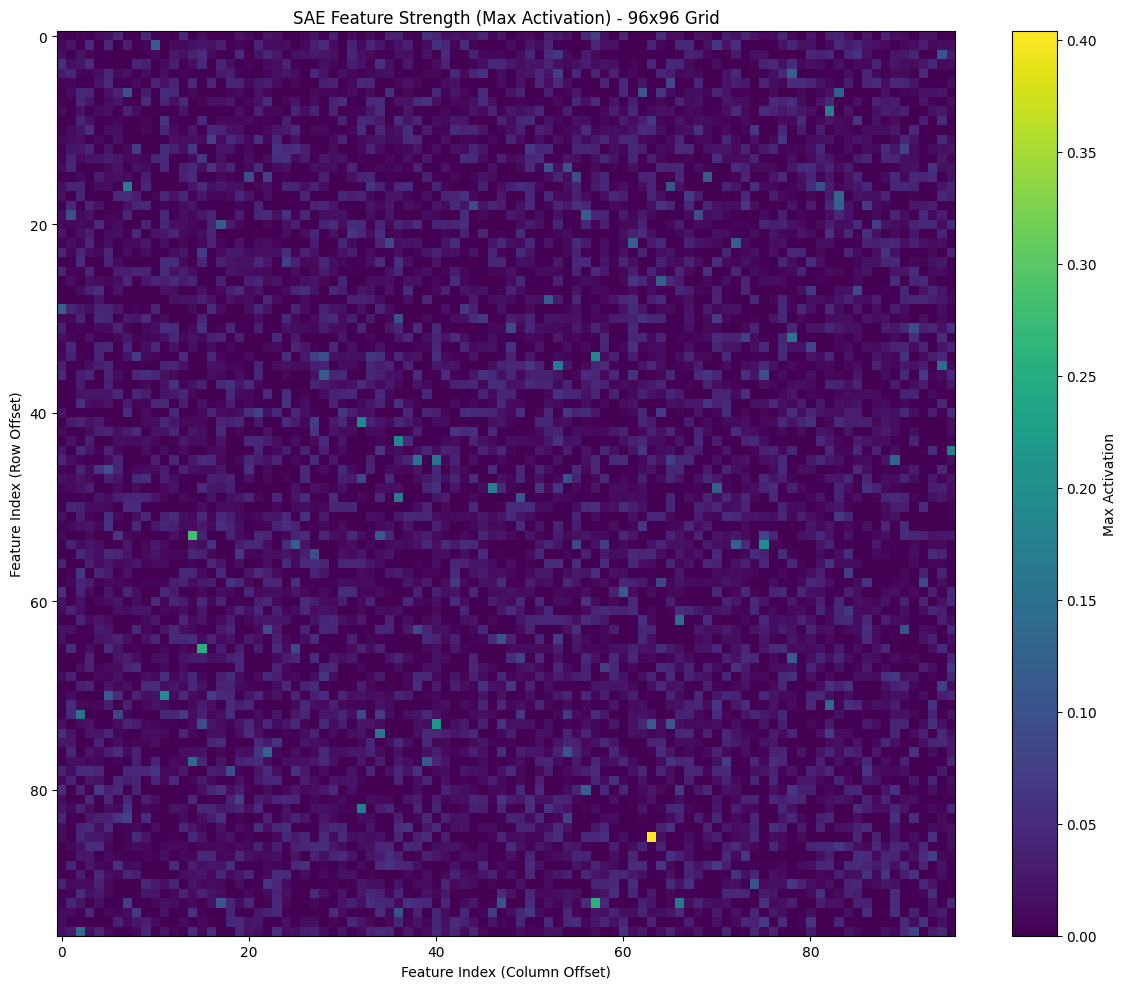


Generating 3D bar plot (can be slow and cluttered)...


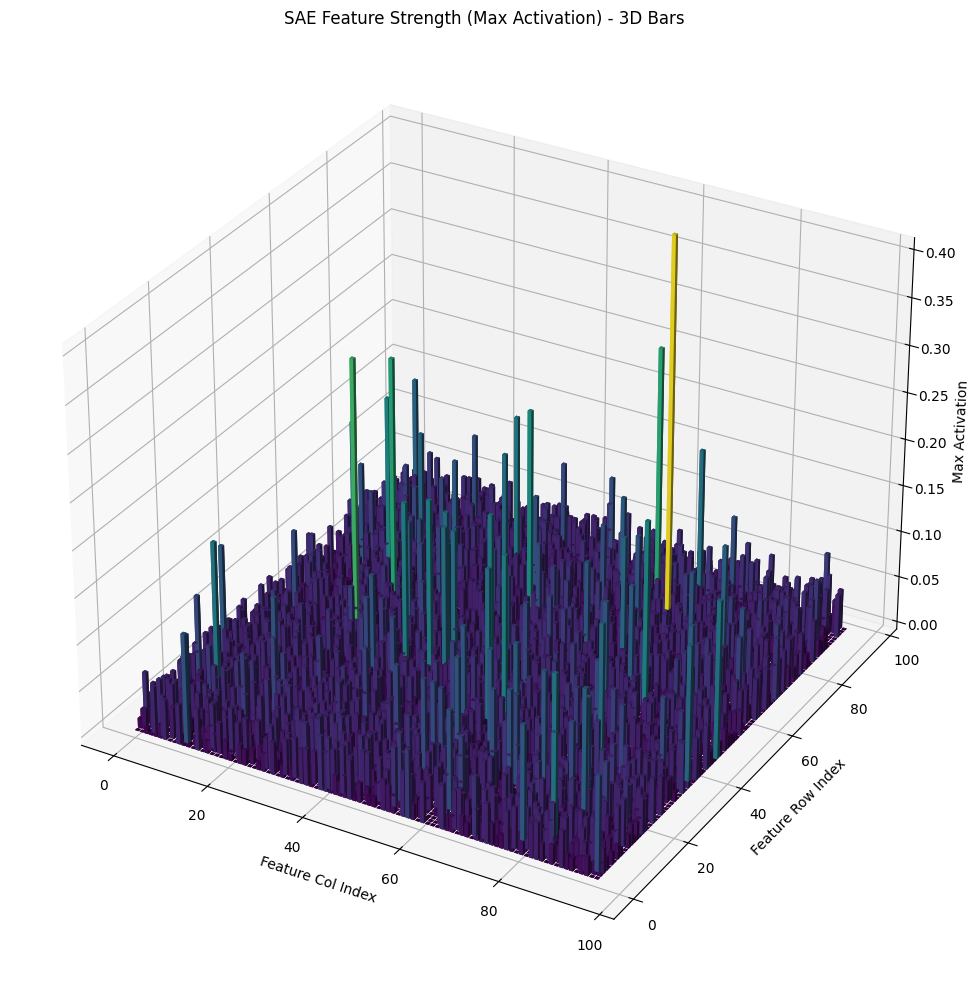

In [21]:
# Option 1: Maximum Activation (Recommended for seeing peak usage)
feature_strengths_np = torch.max(all_sae_features, dim=0)[0].numpy()
metric_label = "Max Activation"

# # Option 2: Mean Activation
# feature_strengths = torch.mean(all_sae_features, dim=0)
# metric_label = "Mean Activation"

# # Option 3: Activation Frequency (Approx L0 Norm)
# feature_activity = (all_sae_features > ACTIVITY_THRESHOLD).float() # ACTIVITY_THRESHOLD from config
# feature_strengths = torch.mean(feature_activity, dim=0)
# metric_label = f"Activation Frequency (>{ACTIVITY_THRESHOLD})"
# del feature_activity # Free up memory

print(f"Calculated feature strengths using: {metric_label}")
num_features = SAE_HIDDEN_DIM

def get_grid_dims(n):
    """Finds reasonably square grid dimensions for n items."""
    if n <= 0: return (0,0)
    sqrt_n = math.isqrt(n)
    rows = sqrt_n
    while n % rows != 0:
        rows -= 1
        if rows == 0:
             rows = int(sqrt_n)
             while n % rows != 0:
                 rows +=1
             break

    cols = n // rows
    return (min(rows, cols), max(rows, cols)) if rows > 0 else (1,n)

# 8*1152 = 64*96
if 64 * 48 == num_features:
     grid_rows, grid_cols = 48, 96
     print(f"Using specified grid: {grid_rows}x{grid_cols}")
else:
     grid_rows, grid_cols = get_grid_dims(num_features)
     if grid_rows * grid_cols > num_features:
          print(f"Calculated grid: {grid_rows}x{grid_cols}. Padding needed.")
          padding_size = grid_rows * grid_cols - num_features
          feature_strengths_np = np.pad(feature_strengths_np, (0, padding_size), mode='constant', constant_values=np.nan)
     else:
          print(f"Calculated grid: {grid_rows}x{grid_cols}.")


feature_grid = feature_strengths_np.reshape(grid_rows, grid_cols)

# Plotting

plt.figure(figsize=(12, 10))
plt.imshow(feature_grid, cmap='viridis', aspect='auto') # Alternative without seaborn
plt.colorbar(label=metric_label)
plt.title(f'SAE Feature Strength ({metric_label}) - {grid_rows}x{grid_cols} Grid')
plt.xlabel("Feature Index (Column Offset)")
plt.ylabel("Feature Index (Row Offset)")
plt.tight_layout()
plt.show()

try:
    from mpl_toolkits.mplot3d import Axes3D

    if num_features > 55000:
         print("\nSkipping 3D bar plot: Too many features (>5000), likely unreadable.")
    else:
         print("\nGenerating 3D bar plot (can be slow and cluttered)...")
         fig = plt.figure(figsize=(15, 10))
         ax = fig.add_subplot(111, projection='3d')

         xpos, ypos = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
         xpos = xpos.flatten()
         ypos = ypos.flatten()
         zpos = np.zeros_like(xpos)

         dz = feature_grid.flatten()
         valid_bars = ~np.isnan(dz)

         colors = plt.cm.viridis(dz[valid_bars] / np.nanmax(dz))

         ax.bar3d(xpos[valid_bars], ypos[valid_bars], zpos[valid_bars],
                  dx=0.8, dy=0.8, dz=dz[valid_bars],
                  color=colors, # Use variable colors
                  shade=True)

         ax.set_xlabel('Feature Col Index')
         ax.set_ylabel('Feature Row Index')
         ax.set_zlabel(metric_label)
         ax.set_title(f'SAE Feature Strength ({metric_label}) - 3D Bars')
         plt.tight_layout()
         plt.show()

except ImportError:
    print("\nCould not import Axes3D for 3D plot. Skipping.")
except Exception as e:
    print(f"\nAn error occurred during 3D plot generation: {e}")

In [22]:
# Show token and context
result = {}
for feature_idx in top_max_activation_indices:
    c = get_max_activating_examples(feature_index=feature_idx, num_examples=18, window_size=10)
    result[feature_idx] = c
    for i in c:
        print(f"Token is {i['token']},\nContext: {i['context']}")


--- Finding top activating examples for Feature 8223 ---
Token is  ,
Context:  game against the Knicks at Madison Square Garden on March 28 , 1995 . Boost
Token is  ,
Context:  were killed . In total , the explosion killed about 360 men . The wreck of Campbelt
Token is  ,
Context:  % were Anglican , and 20 @.@ 06 % were of other Christian faiths , Muslim
Token is  ,
Context: 4 m ( 13 ft ) wide and 5 @.@ 207 m ( 
Token is  ,
Context: 5 ft 6 in ) , a beam of 19 @.@ 5 m ( 6
Token is  ,
Context: .2m before tax , compared with a £ 3m profit the Lerner put the club up for
Token is  ,
Context:  records indicate the first gold dollars were produced on May 7 , 1849 ; Longacre
Token is  ,
Context:  number one with first @-@ week sales of 21 @,@ 358 units .
Token is  ,
Context:  , 3 @.@ 8 assists , and 1 @.@ 5 steals per game . He
Token is  ,
Context: ricon Albums Chart . On the issue dated May 17 , 2010 , the
Token is  ,
Context:  the Twins all @-@ time saves leader with 255 , passing Rick Agui

# Debug

In [23]:
print("DEBUG: Inspecting sample SAE features...")
sae_model.eval()
sae_model.to(device) # Ensure model is on GPU

# Use a subset of activations to avoid RAM issues if all_activations is huge
num_inspect_samples = min(5000, all_activations.shape[0]) # Inspect up to 5k samples
sample_indices = torch.randperm(all_activations.shape[0])[:num_inspect_samples]

# Keep activations on CPU for this inspection if they fit, otherwise batch
sample_acts_cpu = all_activations[sample_indices]

batch_size_inspect = 1024
all_sample_features_list = []
with torch.no_grad():
    for i in range(0, num_inspect_samples, batch_size_inspect):
        batch_acts_gpu = sample_acts_cpu[i:i+batch_size_inspect].to(device)
        batch_features_gpu = sae_model.encode(batch_acts_gpu)
        all_sample_features_list.append(batch_features_gpu.cpu()) # Move features to CPU

sample_features = torch.cat(all_sample_features_list, dim=0)

print(f"Sample features shape: {sample_features.shape}") # Should be (num_inspect_samples, SAE_HIDDEN_DIM)
print(f"Sample features min: {sample_features.min():.6f}")
print(f"Sample features max: {sample_features.max():.6f}")
print(f"Sample features mean: {sample_features.mean():.6f}")
print(f"Sample features std: {sample_features.std():.6f}")

# Calculate L0 norm for the sample (more accurate than just min/max/mean)
# Use a small threshold to account for floating point inaccuracies
active_features = (sample_features > 1e-6).float()
avg_l0_per_input = active_features.sum(dim=1).mean().item()
total_active_features = active_features.sum().item()
fraction_active = total_active_features / sample_features.numel()

print(f"\nSample L0 norm (avg active features per input): {avg_l0_per_input:.4f}")
print(f"Total active feature values in sample: {total_active_features}")
print(f"Fraction of active feature values: {fraction_active:.6f}")

# Check proportion of DEAD features (never activate across the sample)
features_never_activated = (active_features.sum(dim=0) == 0).sum().item()
print(f"\nNumber of features that NEVER activated in the sample: {features_never_activated} / {SAE_HIDDEN_DIM}")

del sample_acts_cpu, all_sample_features_list, sample_features, active_features # Cleanup
gc.collect()
if device == torch.device("cuda"):
    torch.cuda.empty_cache()

DEBUG: Inspecting sample SAE features...
Sample features shape: torch.Size([5000, 9216])
Sample features min: 0.000000
Sample features max: 0.270328
Sample features mean: 0.000499
Sample features std: 0.002133

Sample L0 norm (avg active features per input): 1146.9417
Total active feature values in sample: 5734708.0
Fraction of active feature values: 0.124451

Number of features that NEVER activated in the sample: 4954 / 9216


# Create report

In [24]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

def create_experiment_report():
    report_path = f"{log_dir}/report.pdf"

    with PdfPages(report_path) as pdf:
        # Title Page
        plt.figure(figsize=(11, 8))
        plt.text(0.5, 0.8, "Sparse Autoencoder Experiment Report", 
                 ha='center', va='center', fontsize=20)
        plt.text(0.5, 0.6, f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                 ha='center', va='center', fontsize=12)
        plt.text(0.5, 0.5, f"Model: {MODEL_NAME} | Layer: {LAYER_NAME}", 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
        pdf.savefig()
        plt.close()

        # Configuration Summary
        plt.figure(figsize=(11, 8))
        config_text = [
            "=== Configuration Summary ===",
            f"\nModel Architecture:",
            f"- Target Layer: {LAYER_NAME}",
            f"- Activation Dim: {ACTIVATION_DIM}",
            f"\nDataset:",
            f"- Name: {DATASET_NAME} ({DATASET_CONFIG})",
            f"- Samples Stored: {NUM_ACTIVATIONS_TO_STORE:,}",
            f"- Max Sequence Length: {MAX_SEQ_LENGTH}",
            f"- Unit norm enables: {UNIT_NORM}",
            f"\nSAE Architecture:",
            f"- Hidden Dim: {SAE_HIDDEN_DIM}",
            f"- Expansion Factor: {SAE_EXPANSION_FACTOR}",
            f"\nTraining:",
            f"- Epochs: {NUM_EPOCHS}",
            f"- Batch Size: {BATCH_SIZE}",
            f"- Learning Rate: {LEARNING_RATE}",
            f"- L1 Coefficient: {L1_COEFF}"
        ]
        plt.text(0.1, 0.9, "\n".join(config_text), fontsize=10, va='top')
        plt.axis('off')
        pdf.savefig()
        plt.close()

        # Training Curves
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(training_losses['total'], label='Total Loss')
            plt.plot(training_losses['mse'], label='MSE Loss')
            plt.plot(training_losses['l1'], label='L1 Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss Curves')
            plt.legend()
            plt.grid(True)
            pdf.savefig()
            plt.close()
            
    
            # L0 Norm Plot
            plt.figure(figsize=(10, 6))
            plt.plot(training_losses['l0'], label='Avg Active Features', color='purple')
            plt.xlabel('Epoch')
            plt.ylabel('L0 Norm')
            plt.title('Average Active Features per Sample')
            plt.grid(True)
            pdf.savefig()
            plt.close()
        except:
            # Likely the model has been loaded. Load the training data as well
            
            from tensorboard.backend.event_processing import event_accumulator
            import os
    
            # This should be the *exact* path to the directory containing the
            # TensorBoard event files (e.g., 'runs/google_gemma..._logs_2025...')
            # Make sure this variable is set correctly before this point in your script!
            if not os.path.isdir(log_dir):
                print(f"ERROR: log_dir ('{log_dir if 'log_dir' in locals() else 'Not Defined'}') not found or not a directory.")
                print("       Cannot recover TensorBoard data. Skipping plots.")
            else:
                print(f"Reading TensorBoard logs from: {log_dir}")
                # Initialize the EventAccumulator
                acc = event_accumulator.EventAccumulator(log_dir,
                    size_guidance={
                        event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                        event_accumulator.IMAGES: 4,
                        event_accumulator.AUDIO: 4,
                        event_accumulator.SCALARS: 0, # 0 = load all scalars
                        event_accumulator.HISTOGRAMS: 1,
                })
    
                # Reload the accumulator to parse the event files
                acc.Reload()
                
                tags = {
                    'total': 'Loss/Epoch/Total',
                    'mse': 'Loss/Epoch/MSE',
                    'l1': 'Loss/Epoch/L1',
                    'l0': 'L0_Norm/Epoch'
                }
    
                recovered_losses = {key: [] for key in tags}
                data_found = False
    
                # Extract scalar data
                for key, tag in tags.items():
                    if tag in acc.Tags()['scalars']:
                        events = acc.Scalars(tag)
                        recovered_losses[key] = [event.value for event in events]
                        if recovered_losses[key]:
                             data_found = True
                        print(f"  Recovered {len(recovered_losses[key])} points for tag '{tag}'")
                    else:
                        print(f"  WARNING: Tag '{tag}' not found in TensorBoard logs.")

                if not data_found:
                    print("ERROR: No scalar data recovered from TensorBoard logs. Skipping plots.")
                else:
                    if recovered_losses['total'] and recovered_losses['mse'] and recovered_losses['l1']:
                        plt.figure(figsize=(10, 6))
                        plt.plot(recovered_losses['total'], label='Total Loss (Recovered)')
                        plt.plot(recovered_losses['mse'], label='MSE Loss (Recovered)')
                        plt.plot(recovered_losses['l1'], label='L1 Loss (Recovered)')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.title('Training Loss Curves (Recovered from TensorBoard)')
                        plt.legend()
                        plt.grid(True)
                        pdf.savefig()
                        plt.close()
                    else:
                        print("Skipping loss plot due to missing recovered data.")
                        plt.figure(figsize=(10, 6)); plt.text(0.5, 0.5, "Loss data missing", ha='center', va='center'); plt.axis('off'); pdf.savefig(); plt.close()


                    # Plot L0 Norm
                    if recovered_losses['l0']:
                        plt.figure(figsize=(10, 6))
                        plt.plot(recovered_losses['l0'], label='Avg Active Features (Recovered)', color='purple')
                        plt.xlabel('Epoch')
                        plt.ylabel('L0 Norm')
                        plt.title('Average Active Features per Sample (Recovered from TensorBoard)')
                        plt.legend()
                        plt.grid(True)
                        pdf.savefig()
                        plt.close()
                    
        # 3D Feature Strength Plot
        if Axes3D is None or num_features > 55000:
            # Skip if too many features or missing toolkit
            plt.figure(figsize=(11, 8))
            skip_msg = ("3D bar plot skipped: " +
                        ("Too many features (>5000)." if num_features > 5000 else
                         "mpl_toolkits.mplot3d not available."))
            plt.text(0.5, 0.5, skip_msg, ha='center', va='center', fontsize=12)
            plt.axis('off')
            pdf.savefig()
            plt.close()
        else:
            fig = plt.figure(figsize=(15, 10))
            ax = fig.add_subplot(111, projection='3d')

            xpos, ypos = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
            xpos = xpos.flatten()
            ypos = ypos.flatten()
            zpos = np.zeros_like(xpos)

            dz = feature_grid.flatten()
            valid = ~np.isnan(dz)
            colors = plt.cm.viridis(dz[valid] / np.nanmax(dz))

            ax.bar3d(xpos[valid], ypos[valid], zpos[valid],
                     dx=0.8, dy=0.8, dz=dz[valid],
                     color=colors, shade=True)

            ax.set_xlabel('Feature Col Index')
            ax.set_ylabel('Feature Row Index')
            ax.set_zlabel(metric_label)
            ax.set_title(f'SAE Feature Strength ({metric_label}) - 3D Bars')
            plt.tight_layout()
            pdf.savefig()
            plt.close()

        # Feature Analysis
        plt.figure(figsize=(11, 8))
        analysis_text = [
            "=== Feature Analysis ===",
            f"\nFollowing page contains tokens for top \n {NUM_TOP_FEATURES_TO_ANALYZE} Features by Max Activation:",
            f"\nFeature Statistics:",
            f"- Total Features: {SAE_HIDDEN_DIM}",
            f"- Dead Features: {features_never_activated} ({features_never_activated/SAE_HIDDEN_DIM:.1%})",
            f"- Avg Features Active per Sample: {avg_l0_per_input:.1f}"
        ]
        plt.text(0.0, 0.8, "\n".join(analysis_text), fontsize=10, va='top')
        plt.axis('off')
        pdf.savefig()
        plt.close()

        # Token-level Feature Pages
        for activations in result:
            plt.figure(figsize=(11, 8))
            feature_text = f"==FEATURE N. {activations}==\n"
            for act in result[activations]:
                feature_text += f"Token: {act['token']}\nContext: {act['context']}\n--------------------\n"
            plt.text(0.1, 0.9, feature_text, fontsize=7, va='top')
            plt.axis('off')
            pdf.savefig()
            plt.close()

    print(f"Report generated at: {report_path}")

# Generate the report
create_experiment_report()

/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  pdf.savefig()
/tmp/ipykernel_98838/3681805166.py:210: UserWarning: Glyph 3660 (\N{THAI CHARACTER THANTHAKHAT}) missing from font(s) DejaVu Sans.
  pdf.savefig()


Report generated at: runs/wikitext/google_gemma-3-1b-it_model.layers.25.mlp.down_proj_sae_training_logs_20250516-172556/report.pdf
